In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from skimpy import skim
import statsmodels.api as sm

In [2]:
df=pd.read_csv('../datasets/d5.csv')

         Date  Energy Consumption
0  2020-01-01          305.311409
1  2020-01-02          299.374329
2  2020-01-03          307.646359
3  2020-01-04          306.780983
4  2020-01-05          307.579311


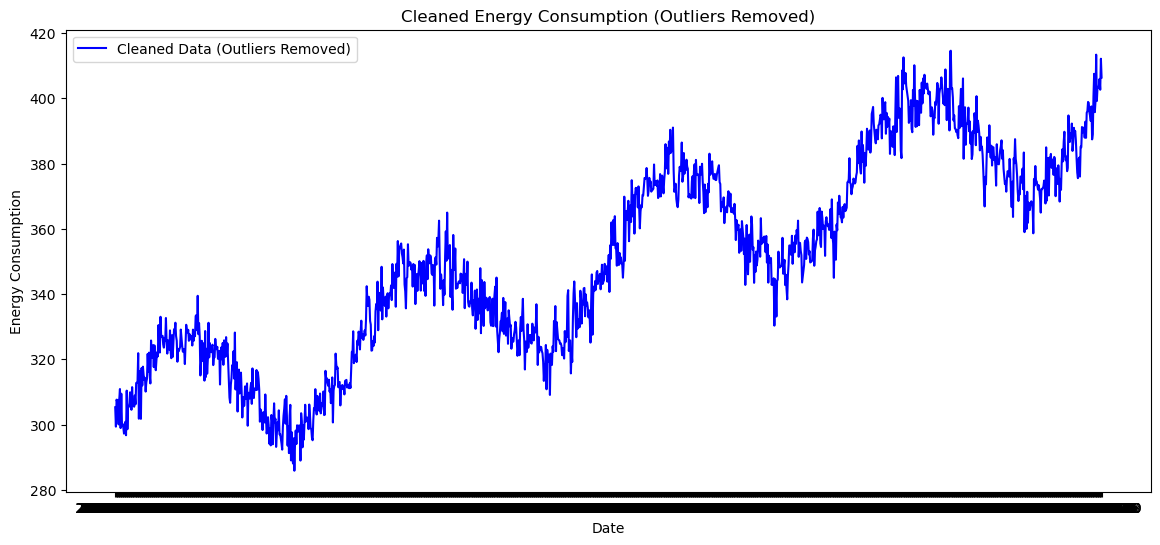

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def zscore(s, window, thresh=1, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

df['Cleaned Energy Consumption'] = zscore(df['Energy Consumption'], window=7)
df = df[['Date', 'Cleaned Energy Consumption']]
df.rename(columns={'Cleaned Energy Consumption': 'Energy Consumption'}, inplace=True)

print(df.head())

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Energy Consumption'], label='Cleaned Data (Outliers Removed)', color='blue')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Cleaned Energy Consumption (Outliers Removed)')
plt.legend()
plt.show()


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df['Energy Consumption'].values.reshape(-1, 1))


In [5]:
data

array([[0.15107583],
       [0.10495639],
       [0.1692138 ],
       ...,
       [0.90714414],
       [0.9809284 ],
       [0.93623882]])

In [6]:
lookback = 15 
X, y = [], []

for i in range(len(data) - lookback):
    X.append(data[i:i + lookback])
    y.append(data[i + lookback])

X, y = np.array(X), np.array(y)



In [7]:
print(scaler.inverse_transform(X.reshape(-1, lookback)).reshape(-1, 1), scaler.inverse_transform(y).reshape(-1, 1))

[[305.31140865]
 [299.37432932]
 [307.64635892]
 ...
 [405.95174739]
 [402.64211031]
 [412.14055521]] [[300.8443893 ]
 [296.73797899]
 [310.40607945]
 ...
 [402.64211031]
 [412.14055521]
 [406.38754639]]


In [8]:
X = torch.FloatTensor(X).view(-1, lookback, 1) 
y = torch.FloatTensor(y)  

In [36]:

class EnergyCNN1D(nn.Module):
    def __init__(self, input_size=15, output_size=1, num_filters=64, kernel_size=1, num_layers=1):
        super(EnergyCNN1D, self).__init__()
        self.conv_layers = nn.ModuleList()
        for i in range(num_layers):
            in_channels = input_size if i == 0 else num_filters
            self.conv_layers.append(nn.Conv1d(in_channels, num_filters, kernel_size=kernel_size))
            self.conv_layers.append(nn.ReLU())
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x):
        # x shape should be (batch_size, num_channels, sequence_length)
        for layer in self.conv_layers:
            x = layer(x)
        
        # Since sequence length is 1, we can directly squeeze it to (batch_size, num_filters)
        x = x.view(x.size(0), -1)  # Flattening the output
        out = self.fc(x)
        return out

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

torch.Size([1156, 15, 1])


In [38]:

input_size = 1
hidden_layer_size = 50
output_size = 1
num_layers = 3
model = EnergyCNN1D(input_size=15, output_size=1, num_filters=64, kernel_size=1, num_layers=2)
outputs = model(X_train)
print(outputs.shape)
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.Size([1156, 1])


In [41]:
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2


In [44]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    train_loss = criterion(outputs, y_train.view(-1, 1))
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test.view(-1, 1))
        val_losses.append(val_loss.item())
        
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Calculate metrics on the validation set after training
with torch.no_grad():
    final_outputs = model(X_test)
    
    # Convert y_test and final_outputs to numpy arrays
    y_test_np = y_test.view(-1, 1).cpu().numpy()  # Ensure y_test is a numpy array
    final_outputs_np = final_outputs.cpu().numpy()  # Ensure outputs are a numpy array
    
    # Calculate metrics
    mse, rmse, r2 = compute_metrics(y_test_np, final_outputs_np)
    
    print(f'Validation MSE: {mse:.4f}')
    print(f'Validation RMSE: {rmse:.4f}')
    print(f'Validation R²: {r2:.4f}')


Epoch [10/100], Train Loss: 0.0015, Validation Loss: 0.0018
Epoch [20/100], Train Loss: 0.0015, Validation Loss: 0.0018
Epoch [30/100], Train Loss: 0.0015, Validation Loss: 0.0018
Epoch [40/100], Train Loss: 0.0015, Validation Loss: 0.0018
Epoch [50/100], Train Loss: 0.0014, Validation Loss: 0.0018
Epoch [60/100], Train Loss: 0.0014, Validation Loss: 0.0018
Epoch [70/100], Train Loss: 0.0014, Validation Loss: 0.0018
Epoch [80/100], Train Loss: 0.0014, Validation Loss: 0.0018
Epoch [90/100], Train Loss: 0.0014, Validation Loss: 0.0018
Epoch [100/100], Train Loss: 0.0014, Validation Loss: 0.0018
Validation MSE: 0.0018
Validation RMSE: 0.0426
Validation R²: 0.9682


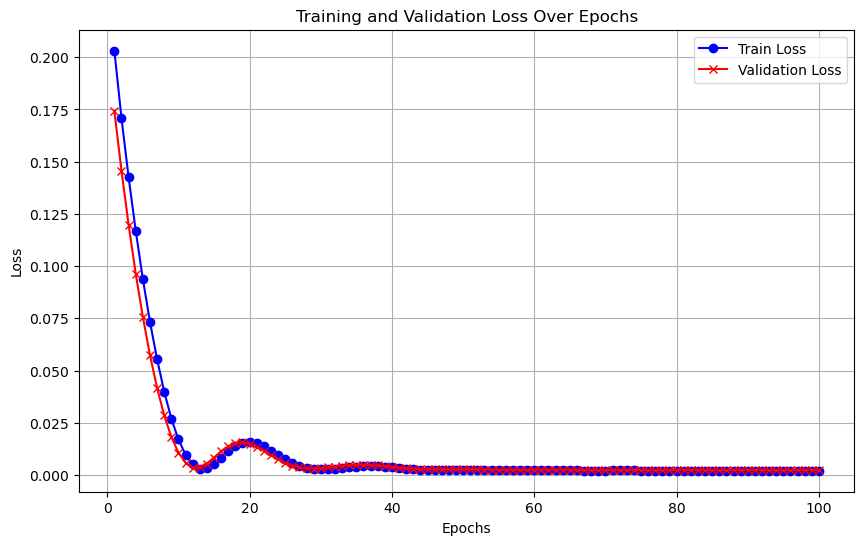

In [40]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
import pandas as pd

# Assuming y_test and final_outputs are your actual and predicted values
y_test_np = y_test.view(-1, 1).cpu().numpy()  # Actual values
final_outputs_np = final_outputs.cpu().numpy()  # Predicted values

# Calculate the errors
errors = final_outputs_np - y_test_np

# Create a DataFrame
results_df = pd.DataFrame({
    'Actual Value': y_test_np.flatten(),
    'Predicted Value': final_outputs_np.flatten(),
    'Error': errors.flatten()
})

# Display the first 7 rows of the DataFrame
print(results_df.head(7))


   Actual Value  Predicted Value     Error
0      0.443522         0.509594  0.066072
1      0.210467         0.220679  0.010213
2      0.582208         0.582675  0.000467
3      0.288295         0.298817  0.010522
4      0.616717         0.537380 -0.079337
5      0.258964         0.280407  0.021443
6      0.153640         0.179339  0.025699
